In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import lmfit
import pandas as pd
import ambigauss

In [2]:
def gaussian(x, amp, center, width):
    """A Gaussian distribution for fitting peaks.

    Parameters
    ----------
    x : numpy.array
        x values for distribution
    center : float
        the center of the distribution
    width : float
        full width at half maximum.

    Returns
    -------
    distribution : numpy array
        normalized Gaussian distribution
    """
    distribution = amp * np.exp(-(x - center)**2/ (2*width**2))
    return distribution

In [3]:
def multigaussian(x, parameters):
    """Build array of gaussians from multiple gaussian parameters.
    """
    # Initialize y array.
    y = np.zeros(len(x))
    
    # Count number of peaks
    n_peaks = int(len(parameters) / 3)
    
    # Simple sanity check.
    if (len(parameters) % 3) != 0:
        raise Exception("Incorrect number of parameters.")
        
    for peak_i in range(n_peaks):
        
        # Get parameters for peak i
        center = parameters['peak_{}_center'.format(peak_i)]
        height = parameters['peak_{}_height'.format(peak_i)]
        width = parameters['peak_{}_width'.format(peak_i)]
        
        # Add peak to y.
        y += gaussian(xdata, height, center, width)
        
    return y

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
peak_0_center    0.9623     -inf      inf  0.03306     True     None     None
peak_0_height     1.078     -inf      inf  0.05982     True     None     None
peak_0_width      0.514     -inf      inf  0.03502     True     None     None
peak_1_center     2.996     -inf      inf 0.004436     True     None     None
peak_1_height     6.015     -inf      inf  0.07725     True     None     None
peak_1_width     0.2986     -inf      inf 0.004454     True     None     None
peak_2_center     5.008     -inf      inf  0.01255     True     None     None
peak_2_height      2.08     -inf      inf  0.07871     True     None     None
peak_2_width     0.2872     -inf      inf  0.01255     True     None     None
peak_3_center     7.995     -inf      inf 0.006626     True     None     None
peak_3_height     4.036     -inf      inf  0.07683     True     None     None
peak_3_width     0.3014     -inf      inf 0.006626     True   

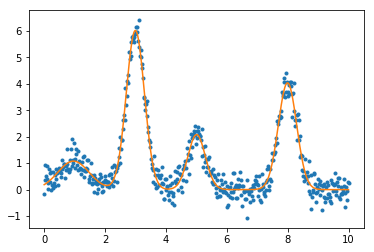

In [34]:
# Simulate noisy 4-peak spectrum
xdata = np.linspace(0, 10, 500)
ydata = gaussian(xdata, 1, 1, .5) + \
        gaussian(xdata, 2, 5, .3) + \
        gaussian(xdata, 6, 3, .3) + \
        gaussian(xdata, 4, 8, .3) + \
        np.random.randn(len(xdata))*.3 # Add noise

        
# Call fit function.
r = ambigauss.fit(xdata, ydata)

# Plot fitter results
xmodel = np.linspace(0,10, 1000)
ymodel = ambigauss.multigaussian(xmodel, r.params)

plt.plot(xdata, ydata , '.')
plt.plot(xmodel, ymodel, '-')
r.params.pretty_print()

plt.savefig('../docs/example.png', format='png', dpi=300, transparent=True)

In [11]:
from scipy.signal import find_peaks_cwt

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
peak_0_center    0.8509     -inf      inf     None     True     None     None
peak_0_height     1.038     -inf      inf     None     True     None     None
peak_0_width        0.1     -inf      inf     None     True     None     None
peak_1_center     3.043     -inf      inf     None     True     None     None
peak_1_height     6.192     -inf      inf     None     True     None     None
peak_1_width        0.1     -inf      inf     None     True     None     None
peak_2_center     5.185     -inf      inf     None     True     None     None
peak_2_height     1.672     -inf      inf     None     True     None     None
peak_2_width        0.1     -inf      inf     None     True     None     None
peak_3_center     6.917     -inf      inf     None     True     None     None
peak_3_height     0.371     -inf      inf     None     True     None     None
peak_3_width        0.1     -inf      inf     None     True   

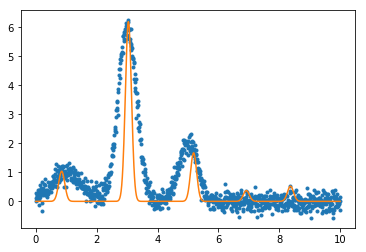

In [13]:
# Identify peaks
index = find_peaks_cwt(ydata, widths=np.arange(1,100))

# Number of peaks
n_peaks = len(index)

# Construct initial guesses
parameters = lmfit.Parameters()

for peak_i in range(n_peaks):
    idx = index[peak_i]
    
    # Add center parameter
    parameters.add(
        name='peak_{}_center'.format(peak_i),
        value=xdata[idx]
    )
    
    # Add height parameter
    parameters.add(
        name='peak_{}_height'.format(peak_i),
        value=ydata[idx]
    )
    
    # Add width parameter
    parameters.add(
        name='peak_{}_width'.format(peak_i),
        value=.1,
    )
    
xmodel = np.linspace(0,10, 1000)
ymodel = multigaussian(xmodel, parameters)

plt.plot(xdata, ydata, '.')
plt.plot(xmodel, ymodel)
parameters.pretty_print()

In [15]:
def residual(params, func, xdata, ydata=None):
    ymodel = func(xdata, params)
    return ydata - ymodel

# Minimize the above residual function.
results = lmfit.minimize(residual, parameters,
                        args=[multigaussian, xdata], 
                        kws={'ydata': ydata})

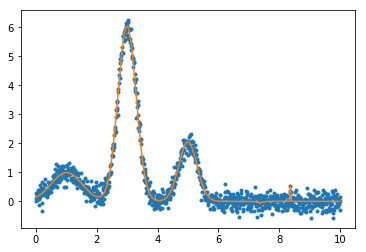

In [16]:
xmodel = np.linspace(0,10, 1000)
ymodel = multigaussian(xmodel, results.params)
plt.plot(xdata, ydata, '.')
plt.plot(xmodel, ymodel)